## Laboratorium 11 - zadania

Na tym laboratorium przebadamy w dużym skrócie technikę uczenia przez transfer i jej wykorzystanie do klasyfikacji obrazów. Naturalnie, technikę tą można użyć do dowolnych zastosowań związanych z przetwarzaniem obrazów (klasyfikacja, segmentacja semantyczna, detekcja, segmentacja instancyjna, ...).

Ideą stojącą za uczeniem przez transfer (*transfer learning*) jest obserwacja, że różne zadania w obrębie jednej modalności są sobie w pewnym stopniu podobne. Intuicja ta jest tym silniejsza w obszarze uczenia głębokiego, gdyż głębokie sieci konwolucyjne (przynajmniej w kontekstach związanych z rozpoznawaniem) dość wyraźnie składają się części ekstrahującej cechy, oraz części klasyfikującej (czy ogólniej: wykonującej jakąś predykcję). Jeśli więc dysponujemy ekstraktorem wystarczająco **ogólnym**, pozwalającym na wyciągnięcie maksymalnie deskryptywnych cech z obrazu, to takie reprezentacje mogą być także dość dobre do rozwiązywania pewnych **szczególnych** zadań, nawet jeśli nie były uczone konkretnie pod to zadanie. *Transfer* polega właśnie na wykorzystywaniu tych wstępnie nauczonych, ogólnych cech do konkretnych, bardziej specyficznych zastosowań. *Learning* natomiast, bo choć wstępnie nauczone cechy stanowią (w założeniu) odpowiednią reprezentację, to nadal konieczne jest douczenie nowego modelu predykcyjnego dla nowego zadania.

Na zajęciach wykorzystamy ponownie dataset twarzy z laboratorium 9, prowadząc klasyfikację binarną twarz/nie twarz.

Do laboratorium potrzebne będą dodatkowo moduły `torchvision` i `torchmetrics` - doinstaluj w razie potrzeby:

In [1]:
%pip install torchvision torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torchvision as tv
import torchvision.models as M
import torchvision.transforms as T

Jeśli uruchamiasz kod przez Google Colab, uzyskaj dostęp do folderu z datasetem i wykorzystaj trick z ZIPem, aby **znacznie** przyspieszyć odczyt danych:

In [3]:
# from google.colab import drive

In [4]:
# drive.mount('/content/gdrive')

In [5]:
# %ll /content/gdrive/MyDrive/

In [6]:
# !unzip "/content/gdrive/MyDrive/dataset.zip" -d "/content" > /dev/null

---

### Dane

Pierwszym krokiem jest utworzenie loadera do danych uczących i testowych. PyTorch znacznie ułatwia ten proces w dodatkowym module `torchvision`, który daje gotową klasę pozwalającą na automatyczne odczytywanie datasetu z podanej ścieżki, z wbudowanym dekodowaniem plików graficznych i tworzeniem etykiet klas na podstawie hierarchii folderów - [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder).

In [7]:
face_dataset = tv.datasets.ImageFolder('natural_images_postprocessed')
len(face_dataset), face_dataset.classes

(1976, ['face', 'noface'])

Należy pamiętać, że pretrenowane modele były nauczone na danych przekształcanych w określony sposób (głównie dotyczy to normalizacji), dlatego konieczne jest odtworzenie tej samej transformacji w procesie douczania. Na szczęście wszystkie modele dostępne w [*model zoo* PyTorcha](https://pytorch.org/vision/stable/models.html) uczone były przy tych samych ustawieniach, a więc z normalizacją odchylenia standardowego i średniej każdego piksela:

$$P_{out} = \frac{P_{in}-[0.485, 0.456, 0.406]}{[0.229, 0.224, 0.225]}$$

W PyTorchu odtworzymy tę ścieżkę przekształceń poprzez dołożenie do datasetu obiektu [`Transform`](https://pytorch.org/vision/stable/transforms.html), powodującego automatyczne przetworzenie każdego sampla przy zwracaniu go z datasetu.

In [8]:
data_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize(size=100),
])

Ostatnim krokiem transformacji jest przeskalowanie do rozmiaru wejściowego oczekiwanego przez klasyfikator. Jeśli jesteśmy pewni, że nasz dataset zawiera tylko sample o stałym rozmiarze, możemy ten krok pominąć - w zadaniu tak jednak nie jest, dlatego wszystkie obrazy przeskalujemy do jednego wymiaru. Ta wartość może być ściśle zdefiniowana i niezmienna dla danego modelu (choć nowsze modele, np. użyty tu ResNet, korzystają z globalnego poolingu na końcu, co uniezależnia je od rozmiaru danych wejściowych).



In [9]:
face_dataset.transform = data_transform # transformację można również przekazać na etapie tworzenia datasetu

In [10]:
train_dataset, val_dataset = torch.utils.data.random_split(face_dataset, lengths=[1383, 593])

Bezpośredni dostęp do danych w PyTorch realizuje się za pomocą [`DataLoader`a](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), który pozwala na dodatkową kontrolę (np. rozmiaru batcha, selekcji sampli) czy automatyczną paralelizację preprocessingu danych. Taki loader daje interfejs `iterable`, przez co możemy z niego korzystać za pomocą idiomu `for batch in loader`.

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

---

### Model

Moduł `torchvision` oferuje całą paletę gotowych, znanych z literatury, oraz wstępnie nauczonych modeli do różnych zastosowań ([`torchvision.models`](https://pytorch.org/vision/stable/models.html)). W przykładzie skorzystamy z modelu ResNet18, ale możesz oczywiście podmienić go na dowolną inną architekturę.

Wybierając gotową architekturę, należy pamiętać o co najmniej dwóch rzeczach. Pierwszą z nich jest wspomniana już kwestia kształtu danych wejściowych. Sieci konwolucyjne generują macierze (tensory) wyjściowe o wielkości zależnej od rozmiaru obrazu wejściowego. Wiele modeli klasyfikacyjnych wykorzystuje do ostatecznej predykcji warstwy pełne (`Linear`) o stałej liczbie wejść (cechy wykryte przez moduł konwolucyjny) i wyjść (liczba klas). Dlatego o ile nie została użyta warstwa globalnego poolingu (np. `AdaptiveAvgPool2d`), to takie modele stają się "zablokowane" dla danego rozmiaru wejścia, i trzeba się z tym liczyć. Oczywistym powinno być również, że jeśli sieć uczona była na modelu barw BGR a my "nakarmimy" ją obrazami RGB czy HSV, to wyniki niekoniecznie będą optymalne.

Drugą sprawą jest kwestia rozmiaru końcowego klasyfikatora. Ponieważ wyjściem sieci jest wektor prawdopodobieństw o długości równej liczbie klas, na których sieć była uczona, to przy przejściu na inny problem (o innych klasach: innej liczbie lub znaczeniu) ten wstępnie nauczony klasyfikator staje się nie tylko bezużyteczny, ale i od strony inżynierskiej niepraktyczny. Należy go zastąpić nowym komponentem.

Zacznijmy od zaimportowania modelu ResNet18 i podejrzenia jego struktury:

In [12]:
net = M.resnet18(pretrained=True)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Widać, że klasyfikator (`net.fc`) przystosowany jest do predykcji dla 1000 klas - wstępne uczenie prowadzone było na zbiorze ImageNet. Moglibyśmy teraz po prostu zastąpić ten klasyfikator nowym, ale my po prostu usuniemy go z modelu (a raczej: zastąpimy pustą operacją), dzięki czemu sieć głęboka będzie służyć nam wyłącznie jako autonomiczny ekstraktor cech, podczas gdy klasyfikator zbudujemy sobie osobno. Będzie to wygodne w procesie douczania.

In [13]:
net.fc = torch.nn.Identity() # no-op
classifier = torch.nn.Linear(512, 2) # dwie klasy - 'twarz' i 'nie-twarz'

---

### Uczenie

Na zajęciach wykorzystamy najbardziej podstawowe podejście do transfer learningu, mianowicie pozostawimy ekstraktor cech bez zmian, a jedynie nauczymy na nim nowy predyktor. Dzięki temu sieć konwolucyjna będzie działać jedynie w trybie forward-pass, a gradienty liczone będą wyłącznie dla lekkiego modelu klasyfikacyjnego.

Ponieważ mamy do czynienia z problemem klasyfikacyjnym, będziemy minimalizować funkcję entropii krzyżowej ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).

In [14]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001) # domyślne ustawienia - dobierz własne jeśli potrzeba

In [15]:
def epoch(extractor, predictor, data_loader, loss_function, optimizer, device='cuda'):
  average_loss = 0.0
  n_batches = 0
  for images, labels in data_loader:
    # ekstrakcja cech - pomijamy gradienty
    with torch.no_grad():
      features = extractor(images.to(device))

    # klasyfikator i funkcja kosztu
    predictions = predictor(features)
    l = loss_function(predictions, labels.to(device))
    l.backward()

    # optymalizacja
    optimizer.step()
    optimizer.zero_grad()
    average_loss += l.item()
    n_batches += 1
  return average_loss / n_batches

Do walidacji modelu na osobnym zbiorze możemy wykorzystać gotowe funkcje z pakietu `torchmetrics`, np. [`torchmetrics.Accuracy`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#id4).

In [16]:
def validate(extractor, predictor, data_loader, device='cuda'):
  acc_metric = torchmetrics.Accuracy()
  accuracies = []
  extractor.eval()
  with torch.no_grad():
    for images, labels in data_loader:
      features = extractor(images.to(device))
      predictions = predictor(features)
      accuracies.append(acc_metric(predictions.to('cpu'), labels))
  return sum(accuracies) / len(accuracies)

---

### Zadanie 1 (1.5 pkt | 1.0 pkt)

Wykonaj proces uczenia klasyfikatora dwukrotnie:
* raz w oparciu o gotowy ekstraktor cech,
* raz w oparciu o surowy, niezainicjowany ekstraktor (optymalizując również jego wagi - zmodyfikuj w tym celu funkcję `epoch`).

Dobierz tak parametry (*learning rate* i stopniowanie, regularyzacja, liczba epok) by osiągnąć sensowne rezultaty, ale nie trać na to zbyt wiele czasu. Ustrukturyzowane metody optymalizacji hiperparametrów są zabronione!

Porównaj osiągane rezultaty korzystając z dowolnych metryk jakości predykcji, ale również w dziedzinie czasu (potrzebnego na nauczenie).

Pamiętaj o korzystaniu z układu GPU:

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
net = net.to(device)
classifier = classifier.to(device)

cuda


In [19]:
loss_fn = torch.nn.CrossEntropyLoss()
for e in range(50):
    print('Epoch', e)
    train_loss = epoch(net, classifier, train_loader, loss_fn, optimizer)
    print('\ttrain loss =', train_loss)
    test_acc = validate(net, classifier, val_loader)
    print('\tvalidation accuracy =', test_acc.item())

Epoch 0
	train loss = 0.015754696637413454
	validation accuracy = 0.9917762875556946
Epoch 1
	train loss = 0.013094390397249111
	validation accuracy = 0.9917762875556946
Epoch 2
	train loss = 0.011092703840989706
	validation accuracy = 0.9917762875556946
Epoch 3
	train loss = 0.00946867101204892
	validation accuracy = 0.9917762875556946
Epoch 4
	train loss = 0.008302286588426295
	validation accuracy = 0.9917762875556946
Epoch 5
	train loss = 0.0073633544751169995
	validation accuracy = 0.9934210777282715
Epoch 6
	train loss = 0.006560005459348382
	validation accuracy = 0.9934210777282715
Epoch 7
	train loss = 0.005971362216173318
	validation accuracy = 0.9934210777282715
Epoch 8
	train loss = 0.005386920073123157
	validation accuracy = 0.9934210777282715
Epoch 9
	train loss = 0.004751674475646096
	validation accuracy = 0.9934210777282715
Epoch 10
	train loss = 0.004585993966293767
	validation accuracy = 0.9934210777282715
Epoch 11
	train loss = 0.004078577740429686
	validation accuracy

Uczenie pretrenowanej sieci dla 50 epok trwało 94s i osiągneło dokładność 0.993 na zbiorze walidacyjnym.

In [20]:
def epoch2(extractor, predictor, data_loader, loss_function, optimizer, device='cuda'):
  average_loss = 0.0
  n_batches = 0
  for images, labels in data_loader:
    # ekstrakcja cech - pomijamy gradienty
    features = extractor(images.to(device))

    # klasyfikator i funkcja kosztu
    predictions = predictor(features)
    l = loss_function(predictions, labels.to(device))
    l.backward()

    # optymalizacja
    optimizer.step()
    optimizer.zero_grad()
    average_loss += l.item()
    n_batches += 1
  return average_loss / n_batches

In [21]:
net = M.resnet18(pretrained=False)
net.fc = torch.nn.Identity() # no-op
classifier = torch.nn.Linear(512, 2) # dwie klasy - 'twarz' i 'nie-twarz'
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # domyślne ustawienia - dobierz własne jeśli potrzeba
net = net.to(device)
classifier = classifier.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

In [22]:
for e in range(50):
    print('Epoch', e)
    train_loss = epoch2(net, classifier, train_loader, loss_fn, optimizer)
    print('\ttrain loss =', train_loss)
    test_acc = validate(net, classifier, val_loader)
    print('\tvalidation accuracy =', test_acc.item())

Epoch 0
	train loss = 0.2168691922567956
	validation accuracy = 0.9786184430122375
Epoch 1
	train loss = 0.1188103710782939
	validation accuracy = 0.9672988057136536
Epoch 2
	train loss = 0.05690169232079877
	validation accuracy = 0.9884868264198303
Epoch 3
	train loss = 0.09094778113682679
	validation accuracy = 0.9884868264198303
Epoch 4
	train loss = 0.050253141240548645
	validation accuracy = 0.9851973652839661
Epoch 5
	train loss = 0.02783039841103774
	validation accuracy = 0.9967105388641357
Epoch 6
	train loss = 0.017060862772665844
	validation accuracy = 0.9835526347160339
Epoch 7
	train loss = 0.04420669453824742
	validation accuracy = 0.9917762875556946
Epoch 8
	train loss = 0.0343272487804208
	validation accuracy = 0.9934210777282715
Epoch 9
	train loss = 0.019432699290194866
	validation accuracy = 0.9819079041481018
Epoch 10
	train loss = 0.019901863377798555
	validation accuracy = 0.9917762875556946
Epoch 11
	train loss = 0.006017056005810278
	validation accuracy = 0.99506

Uczenie nietrenowanej sieci dla 50 epok trwało 129s i osiągneło dokładność 0.998 na zbiorze walidacyjnym.

Dłuższy czas uczenia dla niepretrenowanej sieci jest spodziewany, ponieważ trenujemy większą liczbę parametrów. Bardziej zaskakująca jest poprawa dokładności. Jest ona prawdopodobnie spowodowana przewagą resnetu wytrenowanego dla danego problemu nad pretrenowanym. Przewaga to nadrabia za dodaktowe epoki potrzebne na wytrenowanie resnetu. Ze względu na bardzo dobre wyniki dla domyślnych hiperparametrów, zmienianie ich nie przyniosło znaczących popraw.

### Zadanie 2 (1.5 pkt | 1.0 pkt)

Porównaj działanie obu klasyfikatorów na obrazach testowych. Wykorzystaj ponownie kod podejścia *sliding-window* z laboratorium 9. Aby wycięte z obrazu RoI "uzdatnić do spożycia" przez sieć konwolucyjną, posłuż się poniższym snippetem:

In [23]:
def roi2tensor(roi:np.ndarray, transform):
  # bgr -> rgb, uint8 -> float, 0-255 -> 0.0-0.1
  rearranged = roi[..., ::-1].astype(np.float32) / 255
  # konwersję HWC -> CHW robi już transformacja ToTensor
  tensor = transform(rearranged)
  return tensor[None, ...] # CHW -> NCHW

image = cv2.imread('natural_images_postprocessed/face/person_0535.jpg')
tensor = roi2tensor(image, data_transform)
tensor.shape

torch.Size([1, 3, 100, 100])

In [24]:
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image

def get_image_dl(image, roi_size, transform, step=1):
    rois = []
    coords = []
    for y in tqdm(range(0, image.shape[0] - roi_size[0], step)):
        for x in range(0, image.shape[1] - roi_size[1], step):
            rois.append(roi2tensor(image[y:y + roi_size[0], x:x + roi_size[1]], transform))
            coords.append(torch.tensor([[y, x], [y + roi_size[0], x + roi_size[1]]]))
    return DataLoader(TensorDataset(torch.cat(rois), torch.stack(coords)), pin_memory=True)

def find_faces(extractor, predictor, data_loader, threshold=0.5, device='cuda'):
    extractor.eval()
    coords = []
    for images, coord_batch in tqdm(data_loader):
        features = extractor(images.to(device))
        predictions = torch.softmax(predictor(features), dim=1)
        for (pred, coord) in zip(predictions, coord_batch):
            if pred[0] > threshold:
                coords.append(coord)
    return coords

def show_faces(image, coords):
    for coord in coords:
        cv2.rectangle(image, np.flip(coord[0].numpy()), np.flip(coord[1].numpy()), (0, 0, 255))
    return Image.fromarray(image[...,::-1])

def ff_do_all(filename, transform, net, classifier, face_size, step=1, threshold=0.5):
    image = cv2.imread(filename)
    dl = get_image_dl(image, face_size, transform, step)
    coords = find_faces(net, classifier, dl, threshold)
    return show_faces(image, coords)

100%|██████████| 3577/3577 [00:11<00:00, 317.33it/s]


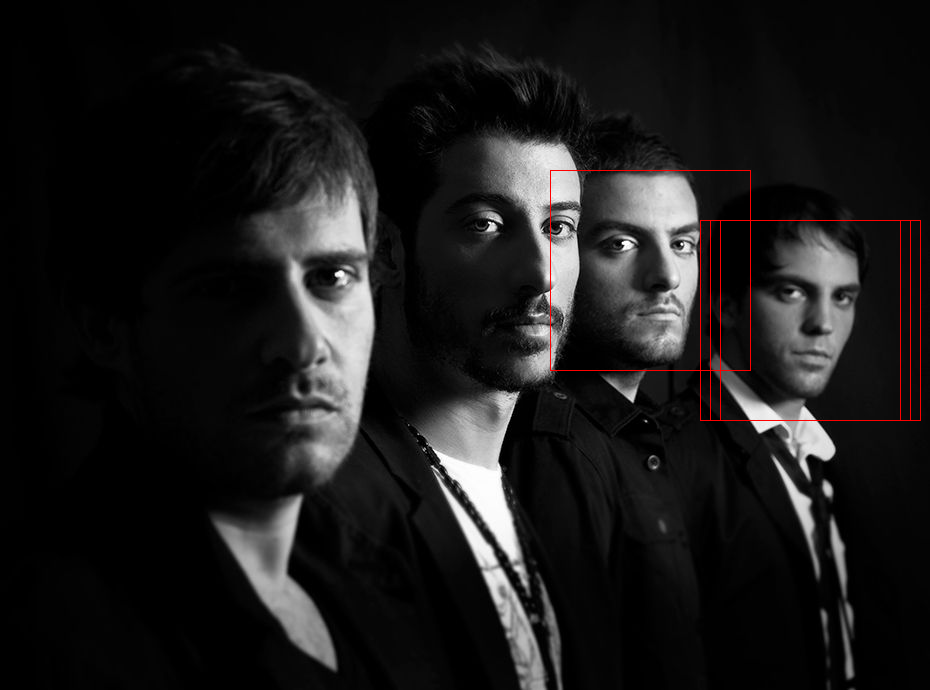

In [43]:
ff_do_all('test_images/band.jpg', data_transform, net, classifier, (200, 200), 10)

100%|██████████| 8968/8968 [00:29<00:00, 308.96it/s]


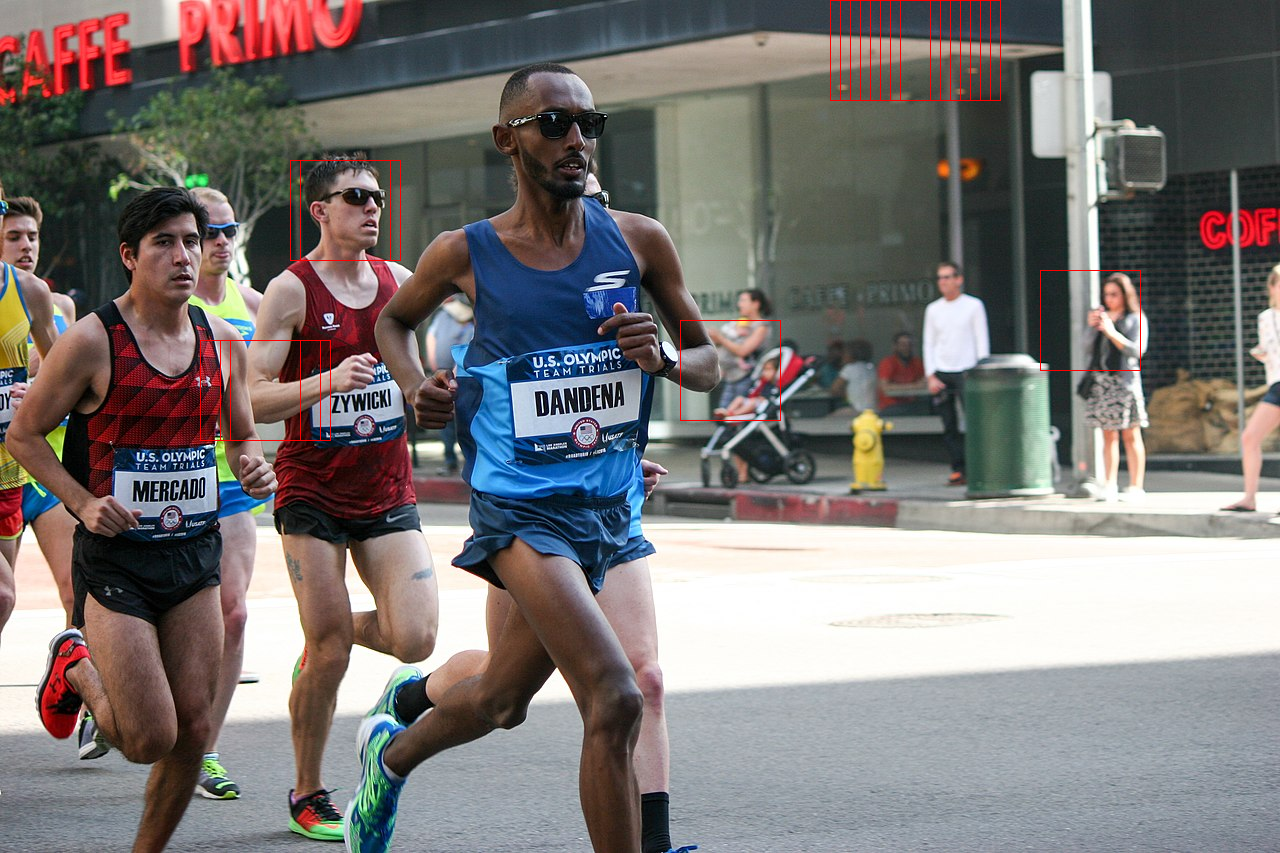

In [47]:
ff_do_all('test_images/marathon.jpg', data_transform, net, classifier, (100, 100), 10, 0.999)

100%|██████████| 12960/12960 [00:41<00:00, 310.23it/s]


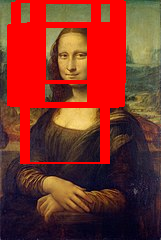

In [32]:
# image = cv2.imread('test_images/MonaLisa161.jpg')
# dl = get_image_dl(image, (80, 80), data_transform, step=1)
# coords = find_faces(net, classifier, dl, threshold=0.9)
# show_faces(image, coords)

ff_do_all('test_images/MonaLisa161.jpg', data_transform, net, classifier, (80, 80), 1, 0.9)

100%|██████████| 2047/2047 [00:06<00:00, 309.25it/s]


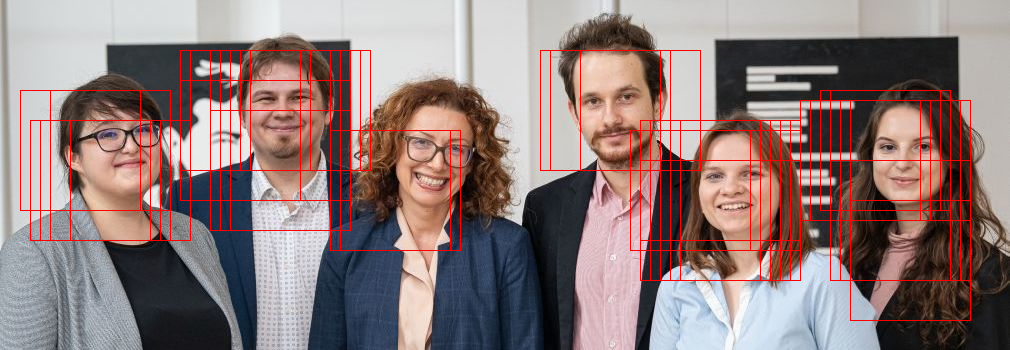

In [41]:
ff_do_all('test_images/pwr_brain_lab.jpg', data_transform, net, classifier, (120, 120), 10, 0.99)

100%|██████████| 4264/4264 [00:13<00:00, 313.91it/s]


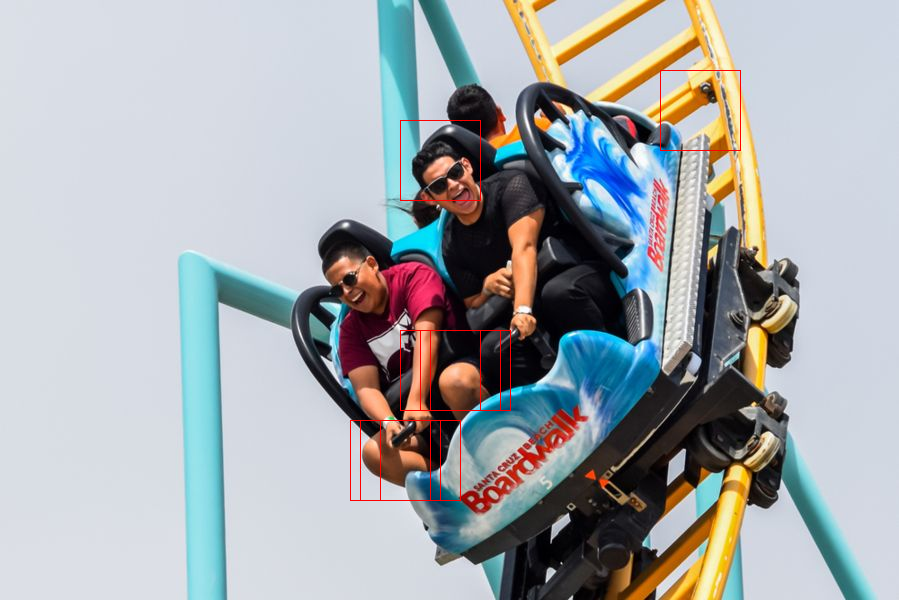

In [29]:
ff_do_all('test_images/roll.jpg', data_transform, net, classifier, (80, 80), 10)

100%|██████████| 7700/7700 [00:24<00:00, 311.63it/s]


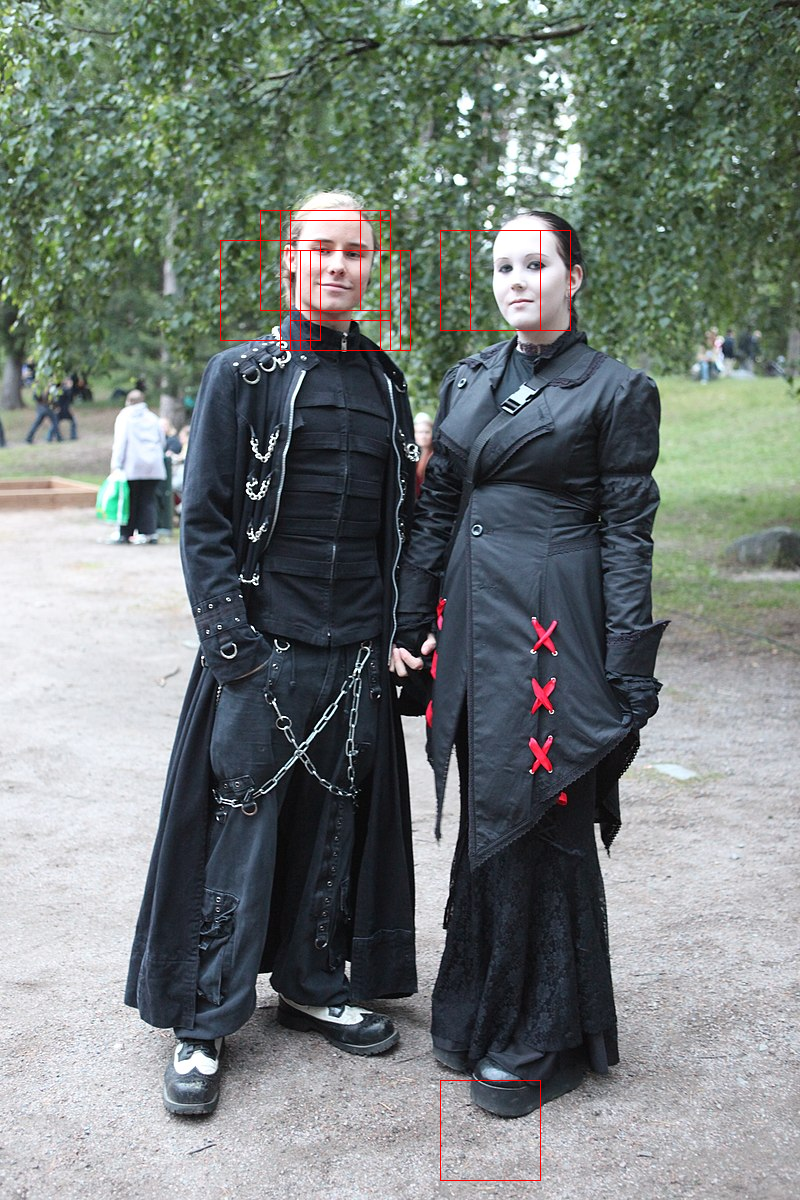

In [31]:
ff_do_all('test_images/typical_finnish_attire.jpg', data_transform, net, classifier, (100, 100), 10)

Jak widać metoda wykorzystująca sieć neuronową (z ekstraktorem trenowanym na miejscu) radzi sobie lepiej od metody z cechami Haara. Mimo to wyniki nie są idealne.

Dla obrazu ``band`` znajdowane są tylko te twarze, które są dopasowane do stałej wielkości okna.

Na obrazie ``MonaLisa161`` wykryto wiele obszarów, z czego niektóre zawierają tylko część twarzy.

Dla obrazów ``pwr_brain_lab`` i ``typical_finnish_attire`` twarze zostały wykryte, ale pojawia się też wiele fałszywych pozytywów. Część okien zawiera też tylko część twarzy.

W przypadku ``marathon`` i ``roll`` metoda ma już duże problemy. Niektóre twarze zostały wykryte, ale większość okien to fałszywe pozytywy.

Błędy metody mogą być tłumaczone stałą wielkością okna i niereprezentacyjnymi danymi treningowymi.